This is the initial exploration into answering this question, as a F1 Team Principal, when should I pit?

I began by building a simple lap simulator that modeled tire degradation using a linear model.

In [5]:
import numpy as np
import pandas as pd

# ------------------------------------------------------------
# 1. Pace Model
# ------------------------------------------------------------
# Simple lap time model:
# base_lap_time + compound_offset + degradation_rate * tyre_age

BASE_LAP_TIME = 93  # seconds, US Gran Prix Austin TX baseline

COMPOUND_OFFSETS = {
    "S": -1.2,   # Softs are fastest
    "M": 0.0,    # Mediums baseline
    "H": +1.5    # Hards are slowest
}

DEGRADATION_RATES = {
    "S": 0.12,   # Softs degrade fastest
    "M": 0.08,
    "H": 0.05
}

PIT_LOSS = 24.0  # seconds lost in pit lane fo Austin TX US Grand Prix


def lap_time(compound, tyre_age):
    """Return lap time given compound and tyre age."""
    return (
        BASE_LAP_TIME
        + COMPOUND_OFFSETS[compound]
        + DEGRADATION_RATES[compound] * tyre_age
    )


# ------------------------------------------------------------
# 2. Simulator
# ------------------------------------------------------------
def simulate_race(strategy, total_laps=56):
    """
    strategy = list of tuples: [(start_compound, pit_lap, new_compound), ...]
    Example:
        [("M", 18, "H"), (None, 40, "S")]
    The first tuple defines the starting compound.
    """
    # Extract starting compound
    start_compound = strategy[0][0]
    current_compound = start_compound
    tyre_age = 0
    total_time = 0.0
    pit_index = 1  # next pit in strategy list

    # Convert strategy to dict for quick lookup
    pit_dict = {pit_lap: new_comp for (_, pit_lap, new_comp) in strategy[1:]}

    lap_times = []

    for lap in range(1, total_laps + 1):

        # Check if this is a pit lap
        if lap in pit_dict:
            total_time += PIT_LOSS
            current_compound = pit_dict[lap]
            tyre_age = 0  # reset after pit

        # Compute lap time
        t = lap_time(current_compound, tyre_age)
        lap_times.append(t)
        total_time += t

        tyre_age += 1

    return total_time, lap_times


# ------------------------------------------------------------
# 3. Try a few strategies
# ------------------------------------------------------------
strategies = {
    "1-stop (M → H)": [
        ("M", 18, "H")
    ],
    "2-stop (M → H → S)": [
        ("M", 18, "H"),
        (None, 40, "S")
    ],
    "Aggressive (S → M → S)": [
        ("S", 12, "M"),
        (None, 38, "S")
    ],
    "1-stop alternative (S → M)": [
        ("S", 20, "M")
    ]
}

results = {}

for name, strat in strategies.items():
    total, laps = simulate_race(strat)
    results[name] = total

# Display results
pd.DataFrame.from_dict(results, orient="index", columns=["Total Race Time (s)"])

,Total Race Time (s)
1-stop (M → H),5331.20
2-stop (M → H → S),5287.20
Aggressive (S → M → S),5265.24
1-stop alternative (S → M),5325.60


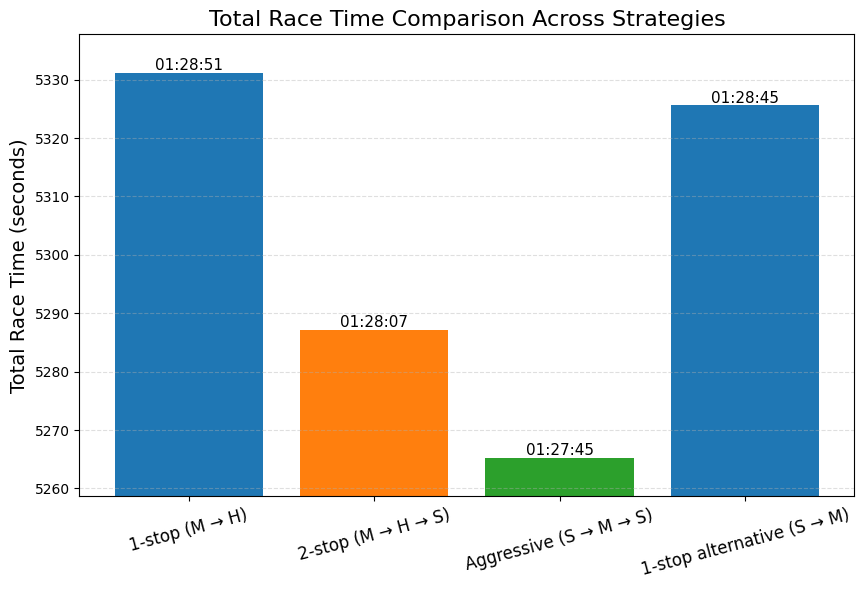

In [2]:
import matplotlib.pyplot as plt

# Convert results dict to a DataFrame (if not already done)
df = pd.DataFrame.from_dict(results, orient="index", columns=["Total Race Time (s)"])

# Helper function to convert seconds → HH:MM:SS
def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{secs:02d}"

# Compute a tighter y-axis range
min_time = df["Total Race Time (s)"].min()
max_time = df["Total Race Time (s)"].max()
padding = (max_time - min_time) * 0.1

plt.figure(figsize=(10, 6))
bars = plt.bar(df.index, df["Total Race Time (s)"], color=["#1f77b4", "#ff7f0e", "#2ca02c"])

# Add HH:MM:SS labels on top of bars
for bar in bars:
    height = bar.get_height()
    label = format_time(height)
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        label,
        ha="center",
        va="bottom",
        fontsize=11
    )

plt.title("Total Race Time Comparison Across Strategies", fontsize=16)
plt.ylabel("Total Race Time (seconds)", fontsize=14)
plt.xticks(rotation=15, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.ylim(min_time - padding, max_time + padding)

plt.show()
